# Модуль1. Промежуточная аттестация

## Модули

In [1]:
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Загрузка датасета

In [2]:
df = sns.load_dataset("mpg")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


## Подсчет количества строк и столбцов

In [3]:
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")

Количество строк: 398
Количество столбцов: 9


## Разведочный анализ данных

### Числовые переменные

In [4]:
num_features = [
    feature for feature in df.columns if df[feature].dtypes in ("float64", "int64")
]
num_features

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year']

In [5]:
num_summary = pd.DataFrame()

for col in num_features:
    num_summary[col] = {
        "Доля пропусков": df[col].isnull().mean(),
        "Макс значение": df[col].max(),
        "Мин значение": df[col].min(),
        "Среднее значение": df[col].mean(),
        "Медиана": df[col].median(),
        "Дисперсия": df[col].var(),
        "Квантиль 0.1": df[col].quantile(0.1),
        "Квантиль 0.9": df[col].quantile(0.9),
        "Квартиль 1": df[col].quantile(0.25),
        "Квартиль 3": df[col].quantile(0.75),
    }
    num_summary[col] = [*map(lambda x: round(x, 2), num_summary[col].values)]

num_summary

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
Доля пропусков,0.00,0.00,0.00,0.02,0.00,0.00,0.00
Макс значение,46.60,8.00,455.00,230.00,5140.00,24.80,82.00
Мин значение,9.00,3.00,68.00,46.00,1613.00,8.00,70.00
Среднее значение,23.51,5.45,193.43,104.47,2970.42,15.57,76.01
Медиана,23.00,4.00,148.50,93.50,2803.50,15.50,76.00
Дисперсия,61.09,2.89,10872.20,1481.57,717140.99,7.60,13.67
Квантиль 0.1,14.00,4.00,90.00,67.00,1988.50,12.00,71.00
Квантиль 0.9,34.33,8.00,350.00,157.70,4275.20,19.00,81.00
Квартиль 1,17.50,4.00,104.25,75.00,2223.75,13.82,73.00
Квартиль 3,29.00,8.00,262.00,126.00,3608.00,17.18,79.00


### Категориальные переменные

In [6]:
cat_features = [feature for feature in df.columns if df[feature].dtypes in ("object",)]
cat_features

['origin', 'name']

In [7]:
cat_summary = pd.DataFrame()

for col in cat_features:
    cat_summary[col] = {
        "Доля пропусков": df[col].isnull().mean(),
        "Количество уникальных значений": df[col].nunique(),
        "Мода": df[col].mode().values[0],
    }

cat_summary

,origin,name
Доля пропусков,0.0,0.0
Количество уникальных значений,3,305
Мода,usa,ford pinto


Набор содержит 2% пропущенных значений в колонке "horsepower", удалим строки с этими значениями.

In [8]:
df = df.dropna(ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    object 
 8   name          392 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 27.7+ KB


В результате удаления потерено всего 6 строк данных, что не является критичным.

## Проверка статистических гипотез

### Гипотеза 1

Существует мнение, что жители США предпочитают использовать автомобили с мощными дигателями, например, пикапы и внедорожники. Для проверки этого сформулируем нулевую и альтернативную гипотезы:

- H0 - Средняя мощность автомобилей (horsepower) в США не больше средней мощности автомобилей в Европе и Японии;
- H1 - Средняя мощность автомобилей в США больше средней мощности автомобилей в Европе и Японии.

In [9]:
# уровень значимости
alpha = 0.05

usa_horsepower = df[df["origin"] == "usa"]["horsepower"].values
euro_japan_horsepower = df[df["origin"] != "usa"]["horsepower"].values

ttest_res = ttest_ind(usa_horsepower, euro_japan_horsepower, alternative="greater")

if ttest_res.pvalue < alpha:
    print(
        "Отвергаем H0 - Средняя мощность автомобилей в США больше средней мощности автомобилей в Европе и Японии."
    )
else:
    print(
        "Не можем отвергнуть H0 - Средняя мощность автомобилей в США не больше средней мощности автомобилей в Европе и Японии."
    )

Отвергаем H0 - Средняя мощность автомобилей в США больше средней мощности автомобилей в Европе и Японии.


Тест показал, что  жители США предпочитают использовать автомобили с более мощными, чем в Европе и Японии дигателями.

### Гипотеза 2

Существует мнение, что спортивные автомобили обладают малыми габаритами и малым весом. Проверим существует ли корреляция между весом автомобиля и его ускорением. Сформулируем нулевую и альтернативную гипотезы:
- H0 - Корреляции между весом автомобиля и его ускорением нет;
- H1 - Существует корреляция между весом автомобиля и его ускорением.

In [10]:
# уровень значимости
alpha = 0.05

pearsonr_res = pearsonr(df["weight"], df["acceleration"])

if pearsonr_res.pvalue < alpha:
    print(
        "Отвергаем H0 - Существует корреляция между весом автомобиля и его ускорением."
    )
    print(f"Коэффициент корреляции: {pearsonr_res.statistic:.2f}")
else:
    print(
        "Не можем отвергнуть H0 - Корреляции между весом автомобиля и его ускорением нет."
    )

Отвергаем H0 - Существует корреляция между весом автомобиля и его ускорением.
Коэффициент корреляции: -0.42


Тест показал, что связь между переменными существует, но она не очень сильная. С увеличением веса автомобиля ускорение имеет тенденцию уменьшаться.

## Реализация градиентного спуска

In [11]:
y = df["mpg"].values
X1 = df["horsepower"].values
X2 = df["weight"].values

In [12]:
def gradient_descent(
    y,
    *args,
    initial_coeffs=None,
    fit_intercept=True,
    stochastic=False,
    lr=0.001,
    max_iters=1000000,
    eps=0.001,
    random_seed=10,
):
    np.random.seed(random_seed)
    m = len(y)

    # проверяем, нужно ли добавлять свободный член
    if fit_intercept:
        vars = [np.ones(m)]  # добавляем вектор из единиц
    else:
        vars = []
    vars.extend(args)  # добавляем остальные переменные

    # инициализируем коэффициенты случайными значениями
    if not initial_coeffs:
        coeffs = [*np.random.randn(len(vars)) * 0.01]
    # используем переданные начальные коэффициенты
    else:
        coeffs = []
        coeffs.extend(initial_coeffs)

    # проверяем, совпадает ли количество переменных и коэффициентов
    if len(vars) != len(coeffs):
        raise Exception("Проверьте *args, initial_coeffs, fit_intercept")

    # история изменения коэффициентов и ошибки на каждой итерации
    coeffs_hist = [[] for _ in range(len(coeffs))]
    error_hist = []

    while len(error_hist) < max_iters - 1:
        # сохраняем текущее значение коэффициентов
        for i in range(len(coeffs)):
            coeffs_hist[i].append(coeffs[i])

        if not stochastic:
            error = sum([coeffs[i] * vars[i] for i in range(len(coeffs))]) - y
            if np.isnan(error).any():
                raise Exception(
                    "Градиентный спуск не сходится! Попробуйте уменьшить initial_coeffs и/или lr"
                )

            # добавляем среднюю норму ошибки в историю
            error_hist.append(np.linalg.norm(error) / m)
            # проверяем условие сходимости
            if np.linalg.norm(error) / m < eps:
                print(
                    "Достигнуто условие сходимости за количество итераций менее max_iters"
                )
                break

            # обновляем коэффициенты по формуле градиентного спуска
            for i in range(len(coeffs)):
                coeffs[i] -= lr * (2 / m) * np.sum(error * vars[i])

        if stochastic:
            idx_random = np.random.randint(m)  # выбираем случайный индекс
            y_random = y[idx_random]  # выбираем случайное значение из y
            vars_random = [
                var[idx_random] for var in vars
            ]  # выбираем соответствующие значения переменных

            # вычисляем ошибку для случайного наблюдения
            error_random = (
                sum(coeff * var for coeff, var in zip(coeffs, vars_random)) - y_random
            )
            # вычисляем общую ошибку
            error = sum([coeffs[i] * vars[i] for i in range(len(coeffs))]) - y
            if np.isnan(error_random).any():
                raise Exception(
                    "Градиентный спуск не сходится! Попробуйте уменьшить initial_coeffs и/или lr"
                )

            # добавляем среднюю норму ошибки в историю
            error_hist.append(np.linalg.norm(error) / m)
            # проверяем условие сходимости
            if np.linalg.norm(error) / m < eps:
                print(
                    "Достигнуто условие сходимости за количество итераций менее max_iters"
                )
                break

            # обновляем коэффициенты для случайного наблюдения
            for i in range(len(coeffs)):
                coeffs[i] -= lr * (2 / m) * error_random * vars_random[i]

    # добавляем последнюю ошибку и состояние коэффициентов в историю
    if max_iters > 0:
        error_hist.append(
            np.linalg.norm(sum([coeffs[i] * vars[i] for i in range(len(coeffs))]) - y)
            / m
        )
        for i in range(len(coeffs)):
            coeffs_hist[i].append(coeffs[i])

    # формируем результат в виде словаря
    result = {
        "coeffs": {"intercept": coeffs[0] if fit_intercept else 0.0}
        | {
            f"w{i - int(fit_intercept)}": coeffs[i]
            for i in range(int(fit_intercept), len(coeffs))
        },
        "coeffs_history": {"intercept": coeffs_hist[0] if fit_intercept else None}
        | {
            f"w{i - int(fit_intercept)}": coeffs_hist[i]
            for i in range(int(fit_intercept), len(coeffs_hist))
        },
        "error_history": error_hist,
    }

    return result

### Обычный градиентный спуск

In [13]:
grad_desc_intercept = gradient_descent(
    y,
    X1,
    X2,
    initial_coeffs=(50, 0.1, 0.1),
    fit_intercept=True,
    stochastic=False,
    lr=0.0000001,
)

grad_desc_intercept["coeffs"]

{'intercept': 49.93717633079343,
 'w0': -0.037076209041633536,
 'w1': -0.007490867276198841}

In [14]:
grad_desc_no_intercept = gradient_descent(
    y,
    X1,
    X2,
    initial_coeffs=(0.1, 0.1),
    fit_intercept=False,
    stochastic=False,
    lr=0.0000001,
)

grad_desc_no_intercept["coeffs"]

{'intercept': 0.0, 'w0': -0.1559045292007087, 'w1': 0.012226710266733219}

### Стохастический градиентный спуск

In [15]:
grad_desc_intercept_stochastic = gradient_descent(
    y,
    X1,
    X2,
    initial_coeffs=(50, 0.1, 0.1),
    fit_intercept=True,
    stochastic=True,
    lr=0.00001,
)

grad_desc_intercept_stochastic["coeffs"]

{'intercept': 49.983943524470476,
 'w0': -0.03751248459685501,
 'w1': -0.008167614488586921}

In [16]:
grad_desc_no_intercept_stochastic = gradient_descent(
    y,
    X1,
    X2,
    initial_coeffs=(0.1, 0.1),
    fit_intercept=False,
    stochastic=True,
    lr=0.00001,
)

grad_desc_no_intercept_stochastic["coeffs"]

{'intercept': 0.0, 'w0': -0.15902795025000274, 'w1': 0.009013690297493295}

### История изменения коэффициентов

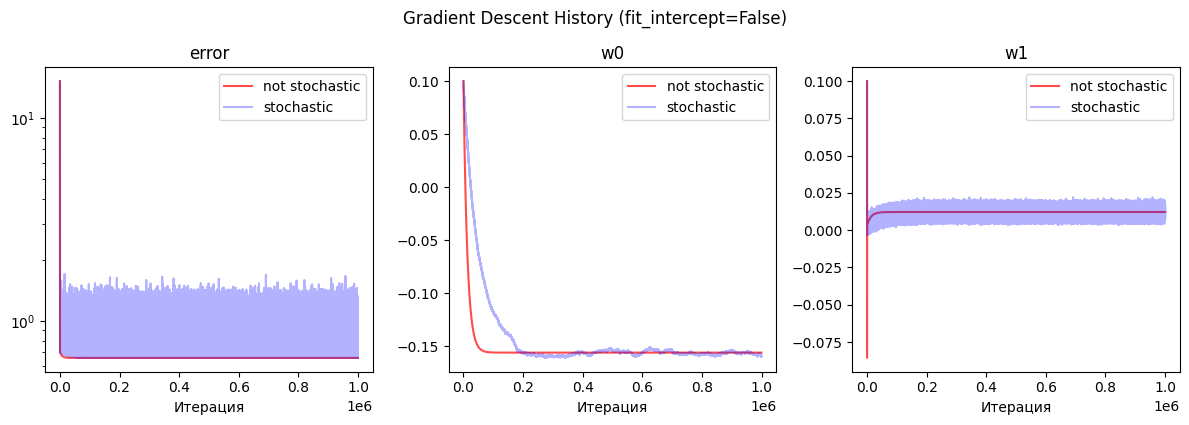

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(
    grad_desc_no_intercept["error_history"], c="r", alpha=0.7, label="not stochastic"
)
ax[0].plot(
    grad_desc_no_intercept_stochastic["error_history"],
    c="b",
    alpha=0.3,
    label="stochastic",
)
ax[0].set_xlabel("Итерация")
ax[0].set_title("error")
ax[0].set_yscale("log")
ax[0].legend()

i = 1
for coeff in grad_desc_no_intercept["coeffs_history"].keys():
    if coeff != "intercept":
        ax[i].plot(
            grad_desc_no_intercept["coeffs_history"][coeff],
            c="r",
            alpha=0.7,
            label="not stochastic",
        )
        ax[i].plot(
            grad_desc_no_intercept_stochastic["coeffs_history"][coeff],
            c="b",
            alpha=0.3,
            label="stochastic",
        )
        ax[i].set_xlabel("Итерация")
        ax[i].set_title(f"{coeff}")
        ax[i].legend()
        i += 1

plt.tight_layout()
plt.suptitle("Gradient Descent History (fit_intercept=False)", y=1.05)
plt.show()

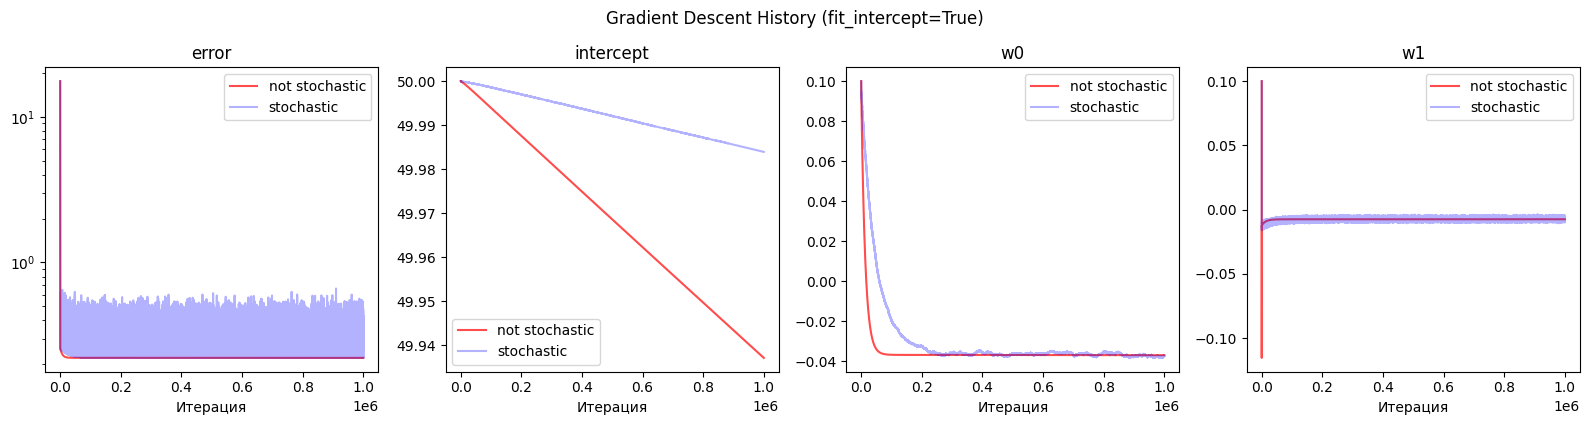

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].plot(
    grad_desc_intercept["error_history"], c="r", alpha=0.7, label="not stochastic"
)
ax[0].plot(
    grad_desc_intercept_stochastic["error_history"],
    c="b",
    alpha=0.3,
    label="stochastic",
)
ax[0].set_xlabel("Итерация")
ax[0].set_title("error")
ax[0].set_yscale("log")
ax[0].legend()

i = 1
for coeff in grad_desc_intercept["coeffs_history"].keys():
    ax[i].plot(
        grad_desc_intercept["coeffs_history"][coeff],
        c="r",
        alpha=0.7,
        label="not stochastic",
    )
    ax[i].plot(
        grad_desc_intercept_stochastic["coeffs_history"][coeff],
        c="b",
        alpha=0.3,
        label="stochastic",
    )
    ax[i].set_xlabel("Итерация")
    ax[i].set_title(f"{coeff}")
    ax[i].legend()
    i += 1

plt.tight_layout()
plt.suptitle("Gradient Descent History (fit_intercept=True)", y=1.05)
plt.show()

Можно отметить следующие особенности при решении заданного уравнения методом градиентного спуска:
- алогоритм не сходится при высоких значениях learning rate и начальных коэффициентов;
- наблюдается очень медленная сходимость свободного члена уравнения из-за малой величины learning rate и высокого масштаба коэффициента по сравнению с остальными коэффициентами;
- обычный градиентный спуск сходится быстрее стохастического;
- средняя норма ошибки ниже для случая с учетом свободного члена уравнения.

### Проверка sklearn

In [19]:
lr_intercept = LinearRegression(fit_intercept=True)
lr_intercept.fit(df.loc[:, ["horsepower", "weight"]].values, df["mpg"].values)

{"intercept": lr_intercept.intercept_} | {
    f"w{i}": lr_intercept.coef_[i] for i in range(len(lr_intercept.coef_))
}

{'intercept': 45.640210840177126,
 'w0': -0.04730286308619176,
 'w1': -0.005794157364802918}

In [20]:
lr_no_intercept = LinearRegression(fit_intercept=False)
lr_no_intercept.fit(df.loc[:, ["horsepower", "weight"]].values, df["mpg"].values)

{"intercept": lr_no_intercept.intercept_} | {
    f"w{i}": lr_no_intercept.coef_[i] for i in range(len(lr_no_intercept.coef_))
}

{'intercept': 0.0, 'w0': -0.1559045292008858, 'w1': 0.012226710266739481}

Для проверки полученного выше результата, уравнение дополнительно было решено с помощью линейной регрессии (пакет sklrearn). Можно заметить, что коэффициенты имеют близкие величины за исключением свободного члена, который не успел сойтись за установленное количество итераций.